# Israel Bus Arrival Times
This notebook was created by Yoav Elkayam as part of the Data Science workshop at the Israel Open University, Spring of 2024.

## Purpose and goal definition
The purpose is to be able to predict bus arrival times based on time-series data of buses.
As a soldier in the IDF, the use of public transportation is on a weekly or even daily basis. It's no secret that public transportation in Israel is not the most punctual type. Failure to meet deadlines causes wasted time, lateness and unwanted delays.

The goal of this notebook is to predict when a bus will arrive at a station.

## Intro

The data being investigated is originated by each registered bus in the MOT (Ministry of Transportation). The data is collected by a group called "The Public Knowledge Workshop (“HASADNA”)". Hasadna collects all data from MOT than enriches it and saves it. It is publicly available by them via api - Open-Bus Stride.

The data we are going to look at is tabular data that has been enriched. In fact, at the source, the data is divided into two: 
1. Data on the planning of the bus schedule (GTFS)
2. Data taken in real time from the buses themselves.
   
The enrichment process that the data goes through connects these two parts according to different test parameters. Finally, the tabular data that is obtained appears in the form of the location of buses at a certain time at the same time as the location of the station closest to it in relation to its route and in addition to this additional data that we will see later.
In the first part of the notebook we will break down the information into these two parts so that later we can draw a route of a bus with the same number of points on the map as the number of bus stops it has to pass. As part of this process, we will calculate the arrival time to the station and this will be the variable that we will finally want to predict as part of the goal of the notebook.

It is important to note - the reason the data is re-decomposed is because it is not possible to obtain the data in its original form in a way that allows working with it. And in addition, a lot of data is used from the enrichment process that the original data goes through.
At the same time, it is important to note that an additional calculation is made of the station closest to the buses, even though, as mentioned, this figure comes with the enriched data - this is because the calculation made in the notebook is slightly more accurate.

The time frame going to be investigated will be January 2023 to October 2023.
This is in order to avoid unexpected changes in the GPS information that were created as a result of the GPS disruptions in the country as a result of the Israel–Hamas war.

## Key terms Dictionary

| Term          | Definition                                                   |
|---------------|--------------------------------------------------------------|
| siri |  Service Interface for Real Time Information. Columns that start with "siri_" has data from real time bus locations pings.|
| gtfs | General Transit Feed Specification. Columns that start with "gtfs_" has data from planned bus schedule |
| Journey | A trip a bus take from its starting station to its last station on a specific route. When a bus send its location information, its related to one journey. Each journey has many location records in the data. |
| Another Term  | Another definition goes here.                                |

# Import Dependencies


In [1]:
# Importing necessary libraries
import os
import glob
import time
import requests
import zipfile
from datetime import timedelta, date
import re

import uuid
import pyarrow.parquet as pq

import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from numba import jit
import concurrent.futures
from sqlalchemy import create_engine



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


# The stride client library, used to make the calls to the stride api
# import stride

### Defining Data location based on current workspace

In [2]:
DATA_FOLDER = './2023_siri_data'

In [ ]:
DATA_FOLDER = './drive/MyDrive/2023_siri_data'

In [18]:
DATA_FOLDER = 'G:\\My Drive\\2023_siri_data'

### Defining Time Boundaries For processing

In [68]:
START_DATE = "2023-01-01"
END_DATE = "2023-10-07"

# Data Collection

Our data is sourced from the Open-Bus Stride ETL packages. These packages provide data in hourly intervals. The data includes information about bus locations, the nearest stop to each bus location, and correlations to the GTFS ride. This includes the date and time of scheduled arrival times, among other details.


## Data Download Function

In this cell, we define a function `download_files` to download and extract the data files for a given year.

The function iterates over each day and hour in the year, constructs the corresponding file URL, and sends a GET request to download the file. If the file is successfully downloaded, it is saved in the 'compressed' directory and then extracted to the 'data' directory.

If the file is not found on the server, its URL is added to a list of missing files, which is printed at the end of the function.

The function also reads and writes the last downloaded date and hour from/to a file, allowing the download process to be resumed if was interrupted.

Finally, we call the function to download the files for the year 2023.


In [3]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def download_files(year):
    start_date = date(year, 1, 1)
    end_date = date(year+1, 1, 1)
    missing_files = []

    if not os.path.exists(f'{DATA_FOLDER}/compressed'):
        os.makedirs(f'{DATA_FOLDER}/compressed')
    if not os.path.exists(f'{DATA_FOLDER}/data'):
        os.makedirs(f'{DATA_FOLDER}/data')

    # Read the start date and hour from a file
    try:
        with open(f'{DATA_FOLDER}/last_downloaded.txt', 'r') as f:
            last_downloaded = f.read().strip()
            start_date = date(int(last_downloaded[:4]), int(last_downloaded[5:7]), int(last_downloaded[8:10]))
            start_hour = int(last_downloaded[11:13])
    except FileNotFoundError:
        start_hour = 0

    for single_date in daterange(start_date, end_date):
        for hour in range(start_hour, 24):
            filename = f"{single_date.strftime('%Y-%m-%d')}.{str(hour).zfill(2)}"
            url = f"https://s3.eu-west-2.wasabisys.com/stride/stride-etl-packages/siri/{single_date.strftime('%Y/%m')}/{filename}.zip"
            response = requests.get(url)
            if response.status_code == 200:
                with open(f"{DATA_FOLDER}/compressed/{filename}.zip", 'wb') as f:
                    f.write(response.content)
                with zipfile.ZipFile(f"{DATA_FOLDER}/compressed/{filename}.zip", 'r') as zip_ref:
                    if f"{filename}.csv" in zip_ref.namelist():
                        zip_ref.extract(f"{filename}.csv", path=f'{DATA_FOLDER}/data')
                # Save the current date and hour to a file
                with open(f'{DATA_FOLDER}/last_downloaded.txt', 'w') as f:
                    f.write(f"{single_date.strftime('%Y-%m-%d')}.{str(hour).zfill(2)}")
            else:
                missing_files.append(url)
        start_hour = 0

    print("Missing files:")
    for file in missing_files:
        print(file)

In [ ]:
# download_files(2023)

## Keeping the data intact

We might have a missing file in the data folder
This function checks for missing files based on the compressed files folder


In [4]:
def extract_missing_csv(data_folder):
    zip_dir = f'{data_folder}/compressed'
    csv_dir = f'{data_folder}/data'
    # Get a list of all ZIP files
    zip_files = glob.glob(f'{zip_dir}/*.zip')
    zip_files.sort()

    for zip_file in zip_files:
        # Get the corresponding CSV file name
        csv_file_name = os.path.basename(zip_file)[:-4] + '.csv'
        csv_file_path = f'{csv_dir}/{csv_file_name}'
        
        # If the CSV file does not exist
        if not os.path.exists(csv_file_path):
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                # Extract the CSV file
                if csv_file_name in zip_ref.namelist():
                    zip_ref.extract(csv_file_name, path=csv_dir)

In [ ]:
extract_missing_csv(DATA_FOLDER)

## Data Processing and Segmentation

This cell is designed to efficiently manage and process large datasets by breaking them down into more manageable chunks, optimizing memory usage, and enhancing data accessibility. The process involves several key steps:

1. **Data Segmentation**: The script segments large CSV files into smaller Parquet files, each containing up to 10 million rows. This segmentation facilitates easier handling of large datasets, as Parquet files are more efficient in terms of storage and speed when accessing subsets of data.

2. **Type Conversion and Cleanup**: It converts data types for specific columns to ensure consistency and optimizes memory usage. For example, it converts certain columns to string, integer, and floating-point types as needed. Additionally, it processes date columns to ensure they are in the correct datetime format.

3. **Column Removal**: To streamline the dataset, the script removes columns that are not immediately necessary for analysis. This step reduces file size and simplifies the dataset, making it easier to work with. The columns to be removed are specified in the [`columns_to_drop`](command:_github.copilot.openSymbolFromReferences?%5B%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22%2FUsers%2Fyoavelkayam%2FDocuments%2FOpenU%2F%D7%A1%D7%93%D7%A0%D7%94%20%D7%91%D7%9E%D7%93%D7%A2%D7%99%20%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%2Fdata-science-project%2Fproject.ipynb%22%2C%22path%22%3A%22%2FUsers%2Fyoavelkayam%2FDocuments%2FOpenU%2F%D7%A1%D7%93%D7%A0%D7%94%20%D7%91%D7%9E%D7%93%D7%A2%D7%99%20%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%2Fdata-science-project%2Fproject.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22X20sZmlsZQ%3D%3D%22%7D%2C%7B%22line%22%3A67%2C%22character%22%3A4%7D%5D "/Users/yoavelkayam/Documents/OpenU/סדנה במדעי הנתונים/data-science-project/project.ipynb") list.

4. **File Management**: The script includes functionality to manage files efficiently. It removes the original CSV files after processing them into Parquet format to free up storage space. It also handles the continuation of data processing from where it left off, by identifying the last processed file and its position, thus avoiding reprocessing of data.

5. **Data Deduplication**: Before appending new data to the dataset, it removes duplicate entries to ensure the uniqueness of records.

6. **Dynamic File Naming**: The output Parquet files are named dynamically based on their content, indicating the range of data they contain. This naming convention makes it easier to identify and access specific segments of data.

7. **Efficient Data Concatenation**: The script concatenates new data to an existing DataFrame until the specified row limit is reached. Once the limit is reached, the data is saved to a Parquet file, and the process continues with the remaining data.

This approach not only optimizes the processing of large datasets by reducing memory overhead but also organizes the data into a more accessible and efficient format, facilitating faster data retrieval and analysis.

In [5]:
def get_folder_size(folder_path):
    total = 0
    for path, dirs, files in os.walk(folder_path):
        for f in files:
            fp = os.path.join(path, f)
            total += os.path.getsize(fp)
    return total

def extract_number(file_name):
    match = re.search(r'output_(\d+)_from_(.+)_at_(\d+)_to_(.+)_at_(\d+)', file_name)
    return int(match.group(1)) if match else 0

def extract_variables(file_name):
    match = re.search(r'output_(\d+)_from_(.+)_at_(\d+)_to_(.+)_at_(\d+)', file_name)
    if match:
        x = int(match.group(1))
        start_file = match.group(2)
        start_pos = int(match.group(3))
        end_file = match.group(4)
        end_pos = int(match.group(5))
        return x, start_file, start_pos, end_file, end_pos
    else:
        return None

def save_df_to_parquet(df, file_counter, start_file, start_pos, last_file, end_pos, files_to_remove, location):
    print(f'Saving file {file_counter}...')
    
    dtypes = {
        'id': 'string',
        'bearing': 'int32',
        'lat': 'float64',
        'lon': 'float64',
        'gtfs_stop_lat': 'float64',
        'gtfs_stop_lon': 'float64',
        }
    
    date_cols = ['recorded_at_time', 'siri_scheduled_start_time', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_arrival_time', 'gtfs_departure_time']
    
    # converting types
    df = df.astype(dtypes)
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%dT%H:%M:%S%z')
    
    start_file_name = os.path.splitext(os.path.basename(start_file))[0]
    last_file_name = os.path.splitext(os.path.basename(last_file))[0]

    file_name = f'{location}/output_{file_counter}_from_{start_file_name}_at_{start_pos}_to_{last_file_name}_at_{end_pos}.parquet'

    df.to_parquet(file_name, index=False)

    # remove csv files
    print(f'Processed files {os.path.basename(files_to_remove[0])} to {os.path.basename(files_to_remove[-2])}. Now Deleting...')
    while len(files_to_remove) > 1:
        os.remove(files_to_remove[0])
        files_to_remove.pop(0)

    if end_pos == -1 and files_to_remove:
        os.remove(files_to_remove[0])
        files_to_remove.pop(0)

def process_files(folder_path, rows_per_file=10000000):
    print(f"Folder size before processing: {get_folder_size(folder_path)} bytes")

    output_files_folder_path = f'{folder_path}\\concatenated_data_parquet\\'

    df = pd.DataFrame()

    columns_to_drop = ['gtfs_agency_name', 'gtfs_stop_name', 'gtfs_route_long_name', 'gtfs_line_ref', 'gtfs_operator_ref', 'distance_from_siri_ride_stop_meters', 'distance_from_journey_start']

    start_file = None
    start_pos = None
    last_file = None
    end_pos = None

    csv_files = glob.glob(f'{folder_path}\\data\\*.csv')

    csv_files.sort()

    file_counter = 1

    output_files = glob.glob(f'{output_files_folder_path}output_*.parquet')

    if output_files:
        last_output_file = max(output_files, key=extract_number)
        file_counter, start_file, start_pos, last_file, end_pos = extract_variables(last_output_file)
        last_df = pd.read_parquet(last_output_file)
        # If the last output file contains less than max rows, load it into df
        if len(last_df) < rows_per_file:
            df = last_df
            os.remove(last_output_file)  # remove the last file as it will be rewritten later
        else:
            start_file = last_file
            start_pos = end_pos
            file_counter += 1
    
    if last_file is not None:
        start_index = csv_files.index(f'{folder_path}\\data\\{last_file}.csv')
    else:
        start_index = 0
        
    files_to_remove = []
    for file in csv_files[start_index:]:
        files_to_remove.append(file)
        # If the file is not empty
        if os.path.getsize(file) > 0:
            print(f'On file {file}')
            try:
                if end_pos is None:
                    end_pos = 0
                if start_file is None:
                    start_file = file

                
                if csv_files.index(file) == start_index:
                    temp_df = pd.read_csv(file, dtype='string', skiprows=range(1, end_pos))
                else:
                    temp_df = pd.read_csv(file, dtype='string')
                print(temp_df.shape[0])
                temp_df['original_file'] = os.path.basename(file)  # Add the original file name to each row
                last_file = file
                
                # Remove duplicates
                temp_df = temp_df.drop_duplicates()

                # Drop the unnecessary columns
                temp_df = temp_df.drop(columns=columns_to_drop)
                df = pd.concat([df, temp_df])
                
                # If the main DataFrame has reached max rows
                print(df.shape[0], temp_df.shape[0])
                if df.shape[0] >= rows_per_file:
                    start_pos = end_pos
                    end_pos = df.shape[0] - rows_per_file
                    save_df_to_parquet(df[:rows_per_file], file_counter, start_file, start_pos, last_file, end_pos, files_to_remove, output_files_folder_path)

                    # Keep the remaining rows in the DataFrame
                    df = df[rows_per_file:]
                    file_counter += 1
                    start_file = file

            except pd.errors.EmptyDataError:
                print(f"File {file} is empty or only contains a header.")
        
    # Write the remaining rows in the DataFrame to a parquet file
    if not df.empty:
        save_df_to_parquet(df, file_counter, start_file, start_pos, last_file, -1, files_to_remove, output_files_folder_path)

    print(f"Folder size after processing: {get_folder_size(folder_path)} bytes")

In [17]:
process_files(DATA_FOLDER)

Folder size before processing: 62382605722 bytes
Folder size after processing: 62382605722 bytes


# Data Examination

In this phase, we will focus on analyzing a single bus line, specifically line 68, which operates from Kiryat Ono terminal to Tel-Aviv central station. Our analysis will be limited to the first month of 2023.

Our primary goal is to identify instances of delays and subsequently investigate potential causes for these delays.

To facilitate this, we will prepare a DataFrame that consolidates all relevant data pertaining to this bus line.


In [6]:
def create_filtered_df(parquet_dir, line_refs, limit=0, offset=0):
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')

    parquet_files.sort(key=extract_number)
    
    if limit > 0:
        parquet_files = parquet_files[offset:offset+limit]
    else:
        parquet_files = parquet_files[offset:]

    df = pd.DataFrame()
    
    counter = 0

    for file in parquet_files:
        # Read the Parquet file
        temp_df = pd.read_parquet(file, filters=[('siri_line_ref', 'in', line_refs)])
        temp = temp_df.astype({'gtfs_stop_lat': float, 'gtfs_stop_lon': float, 'lat': float, 'lon': float})
        df = pd.concat([df, temp_df])
        counter += 1

        if counter % 20 == 0:
            print(f'Processed {counter} files. Current file: {os.path.basename(file)}')

    return df

In [33]:
df = create_filtered_df(f'{DATA_FOLDER}/concatenated_data_parquet', ['989'])

In [31]:
df.head()

,id,bearing,lat,lon,recorded_at_time,velocity,siri_stop_order,siri_scheduled_start_time,siri_duration_minutes,siri_journey_ref,...,gtfs_drop_off_type,gtfs_pickup_type,gtfs_shape_dist_traveled,gtfs_stop_sequence,gtfs_route_short_name,gtfs_route_type,gtfs_route_alternative,gtfs_route_direction,gtfs_route_mkt,original_file
0,1473610653,78,32.054782,34.861351,2023-01-05 12:00:00+02:00,7,8,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,4676,8,68,3,0,2,14068,2023-01-05.12.csv
1,1473616107,76,32.054920,34.862171,2023-01-05 12:00:59+02:00,0,8,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,4676,8,68,3,0,2,14068,2023-01-05.12.csv
2,1473621553,72,32.055068,34.863922,2023-01-05 12:02:03+02:00,0,9,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,5072,9,68,3,0,2,14068,2023-01-05.12.csv
3,1473626930,41,32.055828,34.864608,2023-01-05 12:02:59+02:00,0,9,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,5072,9,68,3,0,2,14068,2023-01-05.12.csv
4,1473632260,340,32.057430,34.864463,2023-01-05 12:03:58+02:00,0,10,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,5477,10,68,3,0,2,14068,2023-01-05.12.csv


## Sorting and Formatting Data

In this step, we sort the dataframe `df` by 'siri_journey_ref' and 'recorded_at_time'. 

We then create two new dataframes:

- `df_bus_journey_stops`: This dataframe is created by selecting specific columns from `df_sorted` and dropping duplicates. It contains information about the bus journey stops.

- `df_locations`: This dataframe is created by excluding columns that start with 'gtfs' from `df_sorted`. It contains information about the bus locations from siri.


In [7]:
def process_dataframe(df):
    df_sorted = df.sort_values(['siri_journey_ref', 'recorded_at_time'])
    
    bus_journey_cols = ['id','siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_stop_order', 'siri_operator_ref', 'siri_line_ref', 'gtfs_journey_ref', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'gtfs_stop_city', 'gtfs_arrival_time', 'gtfs_stop_sequence', 'gtfs_route_short_name', 'gtfs_route_direction', 'gtfs_route_mkt']
    df_bus_journey_stops = df_sorted[bus_journey_cols].drop_duplicates()

    # Remove rows where 'gtfs_stop_lat' or 'gtfs_stop_lon' is NaN
    df_bus_journey_stops = df_bus_journey_stops.dropna(subset=['gtfs_stop_lat', 'gtfs_stop_lon'])

    location_cols = [col for col in df_sorted.columns if not col.startswith('gtfs')]
    df_locations = df_sorted[location_cols]

     # Remove journeys where all locations have the same lat and lon
    journey_counts = df_locations.groupby('siri_journey_ref')[['lat', 'lon']].nunique()
    journeys_to_keep = journey_counts[(journey_counts['lat'] > 2) | (journey_counts['lon'] > 2)].index
    df_locations = df_locations[df_locations['siri_journey_ref'].isin(journeys_to_keep)]
    df_bus_journey_stops = df_bus_journey_stops[df_bus_journey_stops['siri_journey_ref'].isin(journeys_to_keep)]
    df_bus_journey_stops.drop_duplicates(subset=['gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'siri_journey_ref'], inplace=True)


    return df_bus_journey_stops, df_locations

In [86]:
df_bus_journey_stops, df_locations = process_dataframe(df)

## Calculating Distance and Speed

In this step, we define a function `calculate_distance_and_speed` to calculate the distance and speed for each journey.

- The `haversine` function calculates the distance between two points on the Earth's surface given their latitudes and longitudes.
- It then calculates the time difference between consecutive locations and uses this to calculate the speed.
- Any `NaN` values in the 'speed', 'distance', and 'time_diff' columns are replaced with 0.

Finally, we apply this function to our DataFrame `df_locations` using the `groupby` and `apply` methods, and reset the index.


In [29]:
# Pre-calculate constants outside the function
earth_radius = 6367 * 2 * np.pi

@jit(nopython=True)
def haversine(lat1, lon1, lat2, lon2):

    # Convert coordinates to radians (vectorized)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula (vectorized operations)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return earth_radius * c

def calculate_distance_and_speed(group):
    
    lats = group['lat'].values
    lons = group['lon'].values

    # Vectorized haversine calculation
    distances = haversine(lats[:-1], lons[:-1], lats[1:], lons[1:])

    # Add distance and time difference columns
    group['distance'] = np.append(distances, np.nan)
    group['time_diff'] = (group['recorded_at_time'].shift(-1) - group['recorded_at_time']).dt.total_seconds() / 3600

    # Calculate speed
    group['speed'] = group['distance'] / np.maximum(group['time_diff'], 1e-9)

    # Replace NaN values with 0
    group['speed'] = np.nan_to_num(group['speed'])
    group['distance'] = np.nan_to_num(group['distance'])
    group['time_diff'] = np.nan_to_num(group['time_diff'])

    return group

def process_locations(df_locations):
    df_locations = df_locations.groupby('siri_journey_ref').apply(calculate_distance_and_speed)
    df_locations.reset_index(drop=True, inplace=True)
    return df_locations


In [80]:
df_locations = process_locations(df_locations)

## Calculating Arrival Times

In this step, we define several functions to calculate the estimated arrival times at each bus stop for each journey.

- The `calculate_bearing` function calculates the bearing between two points on the Earth's surface.
- The `calculate_arrival_times` function uses the above  function and the haversine function to estimate the arrival times at each bus stop for each journey. It takes into account the speed of the bus, the distance to the next stop, and the direction of the bus.

An important part of the `calculate_arrival_times` function is the calculation of the 'moving_towards_stop' field. This field is a boolean that indicates whether the bus is moving towards or away from the stop. It is calculated by comparing the bearing of the bus to the bearing of the line from the bus to the stop. If the bus's bearing is within a certain range of the bearing to the stop, then the bus is considered to be moving towards the stop. This calculation is important because it allows us to distinguish between a bus that is approaching a stop and a bus that has already passed a stop.

The 'distance_from_stop' field is the distance from the closest bus location to the stop. It is calculated using the `haversine` function.

The 'estimated_arrival_time' field is the estimated time that the bus will arrive at the stop. It is calculated by adding the estimated time to the stop (which is the distance to the stop divided by the speed of the bus) to the time that the closest location was recorded. If the bus is moving away from the stop, the estimated time to the stop is subtracted from the recorded time instead.

Finally, we call the `calculate_arrival_times` function to calculate the estimated arrival times for our data.


In [44]:
@jit(nopython=True)
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the difference in longitudes
    dlon = lon2 - lon1

    # Calculate the bearing
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(x, y))

    # Normalize the bearing to be between 0 and 360
    return (bearing + 360) % 360

def calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=15):
    results = []

    df_locations['speed'] = df_locations['speed'].replace(0, np.nan)

    grouped_locations = df_locations.groupby('siri_journey_ref')

    for journey, journey_locations in grouped_locations:
        journey_stops = df_bus_journey_stops[df_bus_journey_stops['siri_journey_ref'] == journey]

        # Skip the journey if it only has 2 or fewer stops
        if len(journey_stops) <= 2:
            continue
        
        journey_locations = journey_locations.sort_values('recorded_at_time')

        # Interpolate to fill NaN values with the nearest non-NaN values
        journey_locations['speed'] = journey_locations['speed'].interpolate(method='nearest', limit_direction='both')

        # Calculate the mean speed excluding the start and end points
        mean_speed = journey_locations['speed'][1:-1].mean()

        # Fill remaining NaN values at the start and end of the series with the mean speed
        journey_locations['speed'] = journey_locations['speed'].fillna(mean_speed)

        latitudes = journey_locations['lat'].values
        longitudes = journey_locations['lon'].values

        journey_tree = KDTree(list(zip(latitudes, longitudes)), leafsize=4)

        for i, stop in journey_stops.iterrows():
            _, closest_location_idx = journey_tree.query((stop['gtfs_stop_lat'], stop['gtfs_stop_lon']))
            closest_location = journey_locations.iloc[closest_location_idx]

            bearing = calculate_bearing(closest_location['lat'], closest_location['lon'],
                                         stop['gtfs_stop_lat'], stop['gtfs_stop_lon'])

            distance_to_stop = haversine(closest_location['lat'], closest_location['lon'],
                                          stop['gtfs_stop_lat'], stop['gtfs_stop_lon'])

            moving_towards_stop = abs(closest_location['bearing'] - bearing) <= bearing_threshold

            estimated_time_to_stop = (distance_to_stop / closest_location['speed']) * 3600

            if not moving_towards_stop:
                estimated_arrival_time = closest_location['recorded_at_time'] - pd.Timedelta(seconds=estimated_time_to_stop)
            else:
                estimated_arrival_time = closest_location['recorded_at_time'] + pd.Timedelta(seconds=estimated_time_to_stop)

            results.append({
                'siri_journey_ref': journey,
                'gtfs_stop_code': stop['gtfs_stop_code'],
                'closest_location': closest_location['id'],
                'closest_location_lat': closest_location['lat'],
                'closest_location_lon': closest_location['lon'],
                'closet_location_speed': closest_location['speed'],
                'closest_location_bearing': closest_location['bearing'],
                'recorded_at_time': closest_location['recorded_at_time'],
                'distance_from_stop': distance_to_stop,
                'scheduled_arrival_time': stop['gtfs_arrival_time'],
                'estimated_arrival_time': estimated_arrival_time,
                'moving_towards_stop': moving_towards_stop,
                'arrival_time_diff': estimated_arrival_time - stop['gtfs_arrival_time']
            })

    df_results = pd.DataFrame(results)
    df_results = pd.merge(df_bus_journey_stops, df_results, on=['siri_journey_ref', 'gtfs_stop_code'])
    df_results.drop_duplicates(inplace=True)  # Deduplicate results


    return df_results

In [81]:
results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=110)

### Visualizing Bus Locations and Stops for a Specific Journey

In this cell, we are creating a map to visualize the bus locations and stops for a specific journey. This map is centered at the mean latitude and longitude of the journey's locations.

Each bus location is marked with a blue icon, and each stop location is marked with a red icon. If the bus is moving towards the stop, the corresponding marker's popup will show 'Moving Towards Stop: Yes', otherwise it will show 'Moving Towards Stop: No'.

We also draw a blue line connecting all the bus locations and a red line connecting all the stop locations. This visual representation helps us to better understand the 'moving_towards_stop' field that was calculated earlier.

By visualizing a specific journey, we can manually verify if the 'moving_towards_stop' calculation is correct.


In [10]:
def plot_journey(siri_journey_ref, results):
    # Filter the results for the specified journey
    journey_results = results[results['siri_journey_ref'] == siri_journey_ref]

    # Create a map centered at the mean latitude and longitude of the journey's locations
    m = folium.Map(location=[journey_results['closest_location_lat'].mean(), journey_results['closest_location_lon'].mean()], zoom_start=13)

    # Add a marker for each bus location
    for _, row in journey_results.iterrows():
        # Determine whether the bus has already left the stop
        moving_towards_stop = 'Yes' if row['moving_towards_stop'] else 'No'
        
        # Add a marker with a popup showing whether the bus has left the stop
        folium.Marker([row['closest_location_lat'], row['closest_location_lon']], 
                      icon=folium.Icon(color="blue"), 
                      popup=f'Moving Towards Stop: {moving_towards_stop}').add_to(m)
        
    # Add a marker for each stop location
    for _, row in journey_results.iterrows():
        folium.Marker([row['gtfs_stop_lat'], row['gtfs_stop_lon']], icon=folium.Icon(color="red")).add_to(m)

    # Add a line for the bus locations
    bus_locations = journey_results[['closest_location_lat', 'closest_location_lon']].values.tolist()
    folium.PolyLine(bus_locations, color="blue").add_to(m)

    # Add a line for the stop locations
    stop_locations = journey_results[['gtfs_stop_lat', 'gtfs_stop_lon']].values.tolist()
    folium.PolyLine(stop_locations, color="red").add_to(m)

    # Display the map
    return m

In [82]:
plot_journey('2023-01-01-13510915', results)

## Bus Arrival Time Analysis

In this cell, we're performing several key steps to analyze bus arrival times:

1. **Calculate Arrival Time Difference**: We first calculate the difference between the estimated arrival time and the scheduled arrival time for each bus. This is done by subtracting the `scheduled_arrival_time` from the `estimated_arrival_time`. The result is stored in a new column in our DataFrame, `results`, named `arrival_time_diff`.

2. **Define Bus Classification Function**: We then define a function, `classify_bus`, that takes in the arrival time difference and a threshold (in minutes) as parameters. This function classifies the bus status into one of four categories:

   - 'Missing': If the arrival time difference is null.
   - 'Late': If the bus arrived later than the scheduled time by more than the threshold.
   - 'Early': If the bus arrived earlier than the scheduled time by more than the threshold.
   - 'On Time': If the bus arrived within the threshold window.

3. **Apply Classification Function**: We set the threshold to 3 minutes and apply the `classify_bus` function to the `arrival_time_diff` column of our DataFrame. The resulting bus status for each row is stored in a new column, `bus_status`.

This preprocessing is key step as it allows us to categorize bus arrival times and understand the distribution of 'Late', 'Early', 'On Time', and 'Missing' statuses across different bus journeys. This categorized data can then be used for further analysis, such as identifying patterns or trends in bus arrival times, or investigating the factors that might influence a bus's punctuality.


In [11]:
def classify_bus(arrival_time_diff, threshold):
    if pd.isnull(arrival_time_diff):
        return 'Missing'
    elif arrival_time_diff > pd.Timedelta(minutes=threshold):
        return 'Late'
    elif arrival_time_diff < -pd.Timedelta(minutes=threshold):
        return 'Early'
    else:
        return 'On Time'

def classify_buses(results, threshold = 3):
    results['bus_status'] = results['arrival_time_diff'].apply(lambda x: classify_bus(x, threshold))
    return  results

In [83]:
results = classify_buses(results)

## Analyzing Late Bus Stops

This cell will do the following:

1. **Filter the DataFrame**: The `results` DataFrame is filtered to only include rows where the `bus_status` is 'Late'. This filtered DataFrame, `late_buses`, includes all instances where a bus was late to a stop, regardless of whether it's the same bus or the same journey.

2. **Analyze the 'recorded_at_time' column**: The `recorded_at_time` column of the `late_buses` DataFrame is analyzed to understand the distribution of late bus stops throughout the day. This is done by extracting the hour from the `recorded_at_time` and creating a histogram.

3. **Plot Histogram**: A histogram is plotted to visualize the number of late bus stops for each hour of the day. The x-axis represents the hour of the day (24-hour format), and the y-axis represents the number of late bus stops.


In [12]:
def plot_late_buses(results):
    late_buses = results[results['bus_status'] == 'Late']
    late_buses['recorded_at_time'].dt.hour.hist()
    plt.title('Time of Day for Late Buses')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Late Buses')
    plt.show()

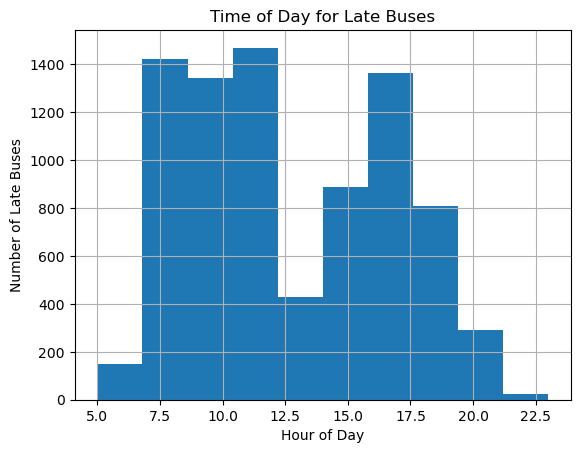

In [68]:
plot_late_buses(results)

# Data Preprocessing and Analysis

The following cell performs several data preprocessing steps on a DataFrame named `results`. Here's a breakdown of what each section does:

1. **Bus Status Conversion**: Converts the 'bus_status' column to numerical values, where 'Late' is represented as 1 and other statuses as 0.

2. **Time Feature Extraction**: Extracts day of the week and hour from 'gtfs_start_time', 'gtfs_end_time', and 'recorded_at_time' columns.


In [46]:
def time_features_extraction(results):
    results['bus_status_num'] = results['bus_status'].apply(lambda x: 1 if x == 'Late' else 0)

    results['gtfs_start_time__day_of_week'] = results['gtfs_start_time'].dt.dayofweek
    results['gtfs_start_time__hour'] = results['gtfs_start_time'].dt.hour

    results['gtfs_end_time__day_of_week'] = results['gtfs_end_time'].dt.dayofweek
    results['gtfs_end_time__hour'] = results['gtfs_end_time'].dt.hour

    results['recorded_at_time__day_of_week'] = results['recorded_at_time'].dt.dayofweek
    results['recorded_at_time__hour'] = results['recorded_at_time'].dt.hour
    results['recorded_at_time__minute'] = results['recorded_at_time'].dt.minute
    results['recorded_at_time__day_of_month'] = results['recorded_at_time'].dt.day
    results['recorded_at_time__month'] = results['recorded_at_time'].dt.month

    results.drop(columns=['gtfs_start_time', 'gtfs_end_time', 'recorded_at_time'], inplace=True)

    return results

In [69]:
results = time_features_extraction(results)

### Analyzing Bus Delays By time features
 
 This cell creates pivot tables for 'recorded_at_time', 'gtfs_start_time', and 'gtfs_end_time' with 'bus_status_num' as values. The pivot tables are indexed by day of the week and hour, and missing values are filled with 0.

The pivot tables provide a summary of the average bus status (late or not) for each hour of each day of the week, for the start time, end time, and recorded time. This can be useful for identifying patterns or trends in bus lateness.

In [13]:
def create_pivot_tables(results):
    def create_pivot_table(df, index_cols, value_col):
        pivot_table = df.pivot_table(index=index_cols, values=value_col, aggfunc='mean')
        all_days_of_week = sorted(df[index_cols[0]].unique())
        all_hours = range(24)
        index = pd.MultiIndex.from_product([all_days_of_week, all_hours], names=index_cols)
        pivot_table = pivot_table.reindex(index)
        pivot_table.fillna(0, inplace=True)
        return pivot_table

    recorded_time_pivot = create_pivot_table(results, ['recorded_at_time__day_of_week', 'recorded_at_time__hour'], 'bus_status_num')
    start_time_pivot = create_pivot_table(results, ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour'], 'bus_status_num')
    end_time_pivot = create_pivot_table(results, ['gtfs_end_time__day_of_week', 'gtfs_end_time__hour'], 'bus_status_num')

    return recorded_time_pivot, start_time_pivot, end_time_pivot

In [71]:
recorded_time_pivot, start_time_pivot, end_time_pivot = create_pivot_tables(results)

#### Heatmap Visualization

This cell generates heatmaps for the pivot tables created in the previous step. The heatmaps visualize the average bus status (late or not) for each hour of each day of the week, for the start time, end time, and recorded time.

Three sets of heatmaps are created:

1. **Recorded Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'recorded_at_time'. Each heatmap represents a day of the week.

2. **Start Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'gtfs_start_time'. Each heatmap represents a day of the week.

3. **End Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'gtfs_end_time'. Each heatmap represents a day of the week.

The color gradient in the heatmaps represents the average bus status, with lighter colors indicating a higher likelihood of the bus being late. This visualization can help identify patterns or trends in bus lateness across different times and days.


In [14]:
def plot_heatmaps(pivot_tables, titles):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    for pivot_table, title in zip(pivot_tables, titles):
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # Remove the extra subplot
        fig.delaxes(axs[1,3])

        for i, day in enumerate(days_of_week):
            sns.heatmap(pivot_table.loc[i], cmap='viridis', ax=axs[i//4, i%4])
            axs[i//4, i%4].set_title(f'Heatmap for {day} - {title}')

        plt.tight_layout()
        plt.show()

KeyError: 4

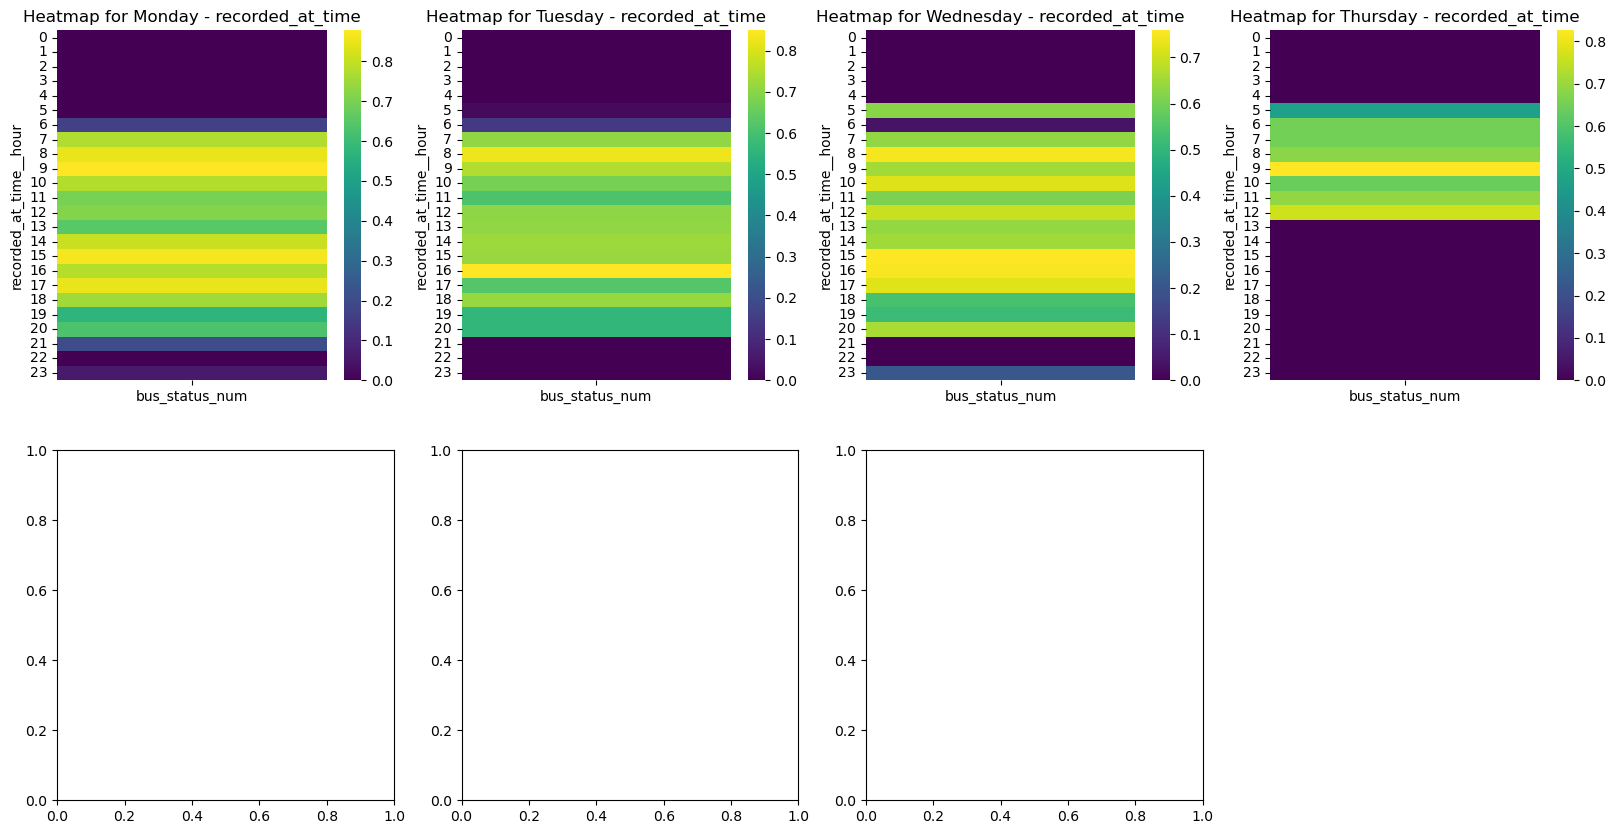

In [73]:
plot_heatmaps([recorded_time_pivot, start_time_pivot, end_time_pivot], ['recorded_at_time', 'gtfs_start_time', 'gtfs_end_time'])

### Analyzing Bus Delays by City

In this analysis, we are investigating the delay of buses across different cities.

The Python code provided creates a pivot table from the `results` DataFrame, using the 'gtfs_stop_city' column as the index and the 'bus_status_num' column as the values. The aggregation function used is 'mean', which gives us the average delay for each city.

A function `reverse_string(s)` is defined and applied to the index of the pivot table to reverse the order of the text.

A heatmap is then created using seaborn's `sns.heatmap()` function, visualizing the average delay of buses in different cities. The color intensity in the heatmap represents the magnitude of the delay.

By examining this heatmap, we can identify which cities experience the most significant bus delays.


In [15]:
def plot_city_heatmap(results):
    pivot_table_city = results.pivot_table(index='gtfs_stop_city', values='bus_status_num', aggfunc='mean')

    def reverse_string(s):
        return s[::-1]

    pivot_table_city.index = pivot_table_city.index.map(reverse_string)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table_city, annot=True, cmap='coolwarm')
    plt.show()

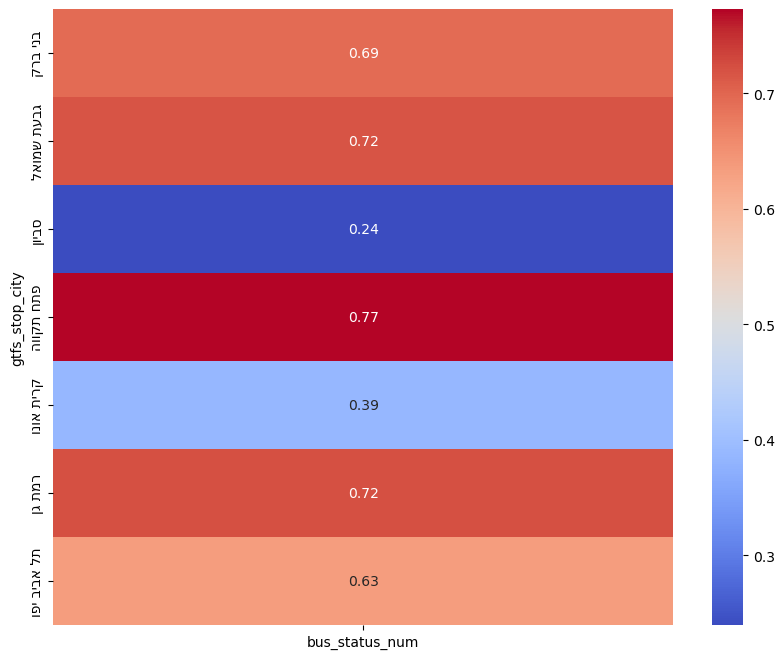

In [76]:
plot_city_heatmap(results)

# Applying Analysis to the Entire Dataset

In this section, we will apply the analysis we have developed to the entire dataset. Given the large size of the data (approximately 800GB), we will process the data in batches. This approach allows us to efficiently handle the data without overloading the memory.

When splitting into batches we can go in few different approaches:
1. Based on batch size limit - in this approach we only care about the size of the batch without any regard to its content.
2. Based on journey_ref - in this approach we will process each journey on its own. The main downside is the amount of batches - millions. which might lead to excessive overhead.
3. based on line_ref - in this approach we will process all journeys of a certain line in each batch. This could be helpful for training a model later in the notebook.
4. based on route_id - similar to the previous approach. could be better for a model training because its more unique.

## Splitting based on batch size

When first starting this part, the approach taken for splitting into batches was the first - based on batch size. 

After many hours of trial and error, many hours of data processing and many many hours of debugging - A conclusion was reached that a different approach was needed and this part must be ditched.

This code is still crucial for the project, so although it won't be used, it will not be deleted.

It should be noted that the code itself works, but every refinement needed in the created batches resulted in a very long wait time for the processing.



The steps we will follow are:

1. **Batch Creation**: We will create data batches, ensuring that each batch does not exceed a specified size limit. To maintain data integrity, we will ensure that all related lines (i.e., lines with the same 'siri_journey_ref') are included in the same batch.

2. **Batch Analysis**: We will apply our analysis to each batch individually. This includes any data cleaning, transformation, and statistical analysis we have previously defined.

3. **Results Aggregation**: After analyzing each batch, we will aggregate the results. This could involve combining the results into a single data structure, or it could involve saving the results of each batch's analysis to disk.

By processing the data in batches, we can scale our analysis to handle large datasets that would not otherwise fit into memory. Let's get started!


### Batch Creation Function

In this cell, we define a function `create_batch_df` to create data batches from the large dataset. The function takes the following parameters:

- `csv_dir`: The directory where the CSV files are stored.
- `batch_size_gb`: The maximum size of each batch in gigabytes.
- `last_journey_refs`: A set of 'siri_journey_ref' values that were included in the last batch and should be excluded from the current batch.
- `start_file`: The file to start reading from. If not specified, reading starts from the first file in the directory.
- `start_pos`: The position in the start file to start reading from.

The function works as follows:

1. It initializes an empty DataFrame for the batch and a set to keep track of the 'siri_journey_ref' values in the current batch.

2. It iterates over each file in the directory, starting from the `start_file` if specified.

3. For each file, it creates an iterator for the chunks in the file and reads the first chunk.

4. If there are any `last_journey_refs`, it excludes them from the chunk.

5. It then enters a loop where it adds the chunk to the batch if it doesn't exceed the `batch_size_gb`. If the batch size is exceeded, it adds only the rows with the same 'siri_journey_ref' as in the current batch.

6. The function returns the batch DataFrame, the set of 'siri_journey_ref' values in the current batch, the next chunk, the iterator for the next chunks, the next file, and the index of the next file.

By using this function, we can create manageable batches from the large dataset while ensuring that all related lines are included in the same batch.


In [16]:
def create_batch_df(parquet_dir, batch_size_gb, last_batch_journey_refs=None, start_file=None, start_pos=0):
    # Convert batch size from GB to bytes
    batch_size_bytes = batch_size_gb * 1024 * 1024 * 1024

    # Get a list of all output Parquet files
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')
    parquet_files.sort(key=extract_number)

    # If a start file is specified, start from this file
    if start_file is not None:
        parquet_files = parquet_files[parquet_files.index(start_file):]

    # Initialize an empty DataFrame for the batch
    batch_df = pd.DataFrame()

    # Initialize a set to keep track of the 'siri_journey_ref' values in the current batch
    current_journey_refs = set()

    for file in parquet_files:
        # Create an iterator for the chunks in the Parquet file
        parquet_file = pq.ParquetFile(file)
        chunk_iter = parquet_file.iter_batches(batch_size=100000)  # Adjust batch size as needed

        # Read the first chunk and convert it to a DataFrame
        chunk = pd.DataFrame(next(chunk_iter).to_pandas())

        # If there are any last journey refs, exclude them from the chunk
        if last_batch_journey_refs is not None:
            chunk = chunk[~chunk['siri_journey_ref'].isin(last_batch_journey_refs)]
        while True:
            # Add the chunk to the batch if it doesn't exceed the batch size
            if (batch_df.memory_usage(index=True, deep=True).sum() + chunk.memory_usage(index=True, deep=True).sum()) <= batch_size_bytes:
                batch_df = pd.concat([batch_df, chunk])
                current_journey_refs.update(chunk['siri_journey_ref'].unique())

            else:
                # If the batch size is exceeded, add only the rows with the same 'siri_journey_ref' as in the current batch
                current_journey_refs_in_chunk = chunk['siri_journey_ref'].isin(current_journey_refs)
                if current_journey_refs_in_chunk.any():
                    batch_df = pd.concat([batch_df, chunk[current_journey_refs_in_chunk]])
                    chunk = chunk[~current_journey_refs_in_chunk]

                # Return the current DataFrame and the set of 'siri_journey_ref' values
                return batch_df, current_journey_refs, chunk, chunk_iter, file, parquet_files.index(file)

            # Try to read the next chunk
            try:
                chunk = pd.DataFrame(next(chunk_iter).to_pandas())
            except StopIteration:
                break

    # If all files have been processed, return the current DataFrame and the set of 'siri_journey_ref' values
    return batch_df, current_journey_refs, None, None, None, None

def process_batch_df(batch_df):
    # Process the DataFrame
    df_bus_journey_stops, df_locations = process_dataframe(batch_df)

    print(f'Processed {len(df_bus_journey_stops)} bus journey stops and {len(df_locations)} locations.')
    # Process the locations
    df_locations = process_locations(df_locations)

    # Calculate the arrival times
    results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=30)

    print(f'Calculated arrival times for {len(results)} stops.')
    # Calculate the bus stats and update the DataFrame
    results = classify_buses(results, threshold=3)

    # Process the results
    results = time_features_extraction(results)

    return results

def save_processed_batch(batch_df):
    batch_num = uuid.uuid4()
    output_file = f'{DATA_FOLDER}/processed_batches/processed_batch_{batch_num}.parquet'
    print(f'Saving processed batch to {output_file}')
    batch_df.to_parquet(output_file, index=False, engine='fastparquet')    

def process_batches_parallel(batch_dfs):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_batch_df, batch_dfs))
    return results

In [17]:
def process_parquet_files(parquet_dir, batch_size_gb, num_batches):
    last_batch_journey_refs = None
    start_file = None
    start_pos = 0

    while True:
        batches = []
        for _ in range(num_batches):
            batch_df, last_batch_journey_refs, remaining_chunk, chunk_iter, start_file, start_pos = create_batch_df(parquet_dir, batch_size_gb, last_batch_journey_refs, start_file, start_pos)
            batches.append(batch_df)

            # If there are no more files to process, break the loop
            if start_file is None:
                break

        if not batches:
            break

        processes_batches =  process_batches_parallel(batches)

        for batch in processes_batches:
            save_processed_batch(batch)

        batches.clear()

    return results

In [18]:
batch_df, _, _, _, _, _ = create_batch_df(f'{DATA_FOLDER}/concatenated_data_parquet', 0.2)

In [24]:
process_parquet_files(f'{DATA_FOLDER}/concatenated_data_parquet', 0.4, 3)

In [22]:
# Specify the directory where your Parquet files are located
parquet_dir = f'{DATA_FOLDER}/concatenated_data_parquet'

# Create a batch of 1GB
batch_df, current_journey_refs, chunk, chunk_iter, file, file_index = create_batch_df(parquet_dir, batch_size_gb=0.2)

print(f'Batch DataFrame shape: {batch_df.shape}')

print(f'Batch size in GB: {batch_df.memory_usage(index=True, deep=True).sum() / 1024**3}')


In [ ]:
import cProfile

def profile_process_batch_df():

    # Use cProfile to profile the function
    profiler = cProfile.Profile()
    profiler.enable()

    # Call the function you want to profile
    process_batch_df(batch_df)

    # Disable the profiler after your function call
    profiler.disable()

    # Print the stats
    profiler.print_stats()

# Call the profiling function
profile_process_batch_df()

## Splitting based on route_id


In [23]:
# Function to establish a connection to the PostgreSQL database
def connect_to_db():
    # Replace the following with your database connection details
    user = 'postgres'
    password = 'postgres'
    host = 'localhost'
    port = '5433'
    db = 'siri_2023'
    return create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}')

def process_chunk(chunk, engine, file_name):
    chunk.to_sql('raw_data', engine, if_exists='append', index=False)
    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Saved a chunk of {file_name} to the database.')

def process_file(file, engine):
    parquet_file = pq.ParquetFile(file)
    chunk_iter = parquet_file.iter_batches(batch_size=1000000)  # Adjust batch size as needed
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        futures = []
        for batch in chunk_iter:
            chunk = pd.DataFrame(batch.to_pandas())
            # Submit each chunk to be processed by one of the workers
            futures.append(executor.submit(process_chunk, chunk, engine, os.path.basename(file)))
        concurrent.futures.wait(futures)

def save_to_db(parquet_dir, engine):
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')
    parquet_files.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit each file to be processed in parallel
        futures = [executor.submit(process_file, file, engine) for file in parquet_files]
        concurrent.futures.wait(futures)



# Connect to the database
engine = connect_to_db()
# save_to_db(f'{DATA_FOLDER}/concatenated_data_parquet', engine)


### Processing Strategy

After deciding to load all data into PostgreSQL, the next step is processing it.

Processing the data still needs to be done in batches. We aim to choose a batching strategy that minimizes processing time. Because using PostgreSQL eliminates many of the complications we encountered earlier with file-based methods, we now have more flexibility in choosing processing strategies. This increased flexibility will not affect the later stages of model training.

When choosing the group, we must choose a group that include an entire journey from start to end.
For example - A group made from the `gtfs_route_mkt` is a good group because each journey has exactly one `gtfs_route_mkt`, On the other end, a group made from `siri_stop_code` is not a good group because each journey has many bus stops.

In [66]:
def create_sql_query(table_name, group_column, value, start_date=None, end_date=None):
    sql_query = f"SELECT * FROM {table_name} WHERE {group_column} = '{value}' AND gtfs_arrival_time IS NOT NULL"
    if start_date is not None and end_date is not None:
        sql_query += f" AND recorded_at_time BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date is not None:
        sql_query += f" AND recorded_at_time >= '{start_date}'"
    elif end_date is not None:
        sql_query += f" AND recorded_at_time <= '{end_date}'"

    return sql_query

def process_single_value(args):
    engine, table_name, group_column, start_date, end_date, value, enable_logging, total_values, index = args
    def log(message):
        if enable_logging:
            print(message)
    
    fetch_start_time = time.time()
    sql_query = create_sql_query(table_name, group_column, value, start_date, end_date)
    df = pd.read_sql(sql_query, engine, parse_dates=['recorded_at_time', 'siri_scheduled_start_time', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_arrival_time', 'gtfs_departure_time'])
    df.drop(columns=['original_file'], inplace=True)
        
    fetch_end_time = time.time()
    log(f"Data for '{value}' in '{group_column}' fetched in {fetch_end_time - fetch_start_time:.2f} seconds.")
    
    group_start_time = time.time()
    
    # Process the data (assuming process_batch_df is a function you've defined to process your data)
    results = process_batch_df(df)
    
    # Save results in db
    results.to_sql('processed_data', engine, if_exists='append', index=False)
    
    group_end_time = time.time()
    log(f" [{index+1}/{total_values}] Processed group '{value}' in '{group_column}' in {group_end_time - group_start_time:.2f} seconds.")

def create_distinct_query(table_name, group_column, limit=None, offset=None):
        distinct_query = f"SELECT DISTINCT {group_column} FROM {table_name} WHERE {group_column} IS NOT NULL AND gtfs_arrival_time IS NOT NULL"
        if limit is not None:
            distinct_query += f" LIMIT {limit}"
        if offset is not None:
            distinct_query += f" OFFSET {offset}"
        return distinct_query

def process_data_grouped_by_column(engine, table_name, group_column, start_date=None, end_date=None, limit=None, offset=None, enable_logging=False):
    start_time = time.time()
    if enable_logging:
        print(f"Starting processing for table '{table_name}' grouped by '{group_column}'")
    
    distinct_query = create_distinct_query(table_name, group_column, limit, offset)
    distinct_values_df = pd.read_sql(distinct_query, engine)
    total_values = len(distinct_values_df)
    if enable_logging:
        print(f"Distinct query executed and fetched {total_values} distinct values.")
    
    if limit is not None:
        distinct_values_df = distinct_values_df.head(limit)     
    
    args = [(engine, table_name, group_column, start_date, end_date, value, enable_logging, total_values, index) for index, value in enumerate(distinct_values_df[group_column])]
    
    # Use ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
        futures = [executor.submit(process_single_value, arg) for arg in args]
        for future in concurrent.futures.as_completed(futures):
            future.result()  # You can handle exceptions here if needed
    
    end_time = time.time()
    if enable_logging:
        print(f"Total processing time for table '{table_name}' grouped by '{group_column}': {end_time - start_time:.2f} seconds.")

In [67]:

process_data_grouped_by_column(engine, 'raw_data', 'gtfs_route_mkt',start_date=START_DATE, end_date=END_DATE, limit=16, offset=200, enable_logging=True)
process_data_grouped_by_column(engine, 'raw_data', 'siri_journey_ref',start_date=START_DATE, end_date=END_DATE, limit=16, offset=1500, enable_logging=True)
process_data_grouped_by_column(engine, 'raw_data', 'siri_vehicle_ref',start_date=START_DATE, end_date=END_DATE, limit=16, offset=150 enable_logging=True)
process_data_grouped_by_column(engine, 'raw_data', 'siri_line_ref',start_date=START_DATE, end_date=END_DATE, limit=16, offset=55, enable_logging=True)

Starting processing for table 'raw_data' grouped by 'gtfs_route_mkt'
Distinct query executed and fetched 2 distinct values.
Data for '10003' in 'gtfs_route_mkt' fetched in 0.07 seconds.
Processed 973 bus journey stops and 1435 locations.


C:\Users\yoave\AppData\Local\Temp\ipykernel_27544\3301279710.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_locations = df_locations.groupby('siri_journey_ref').apply(calculate_distance_and_speed)


Data for '10006' in 'gtfs_route_mkt' fetched in 3.44 seconds.
Calculated arrival times for 971 stops.
Processed 45536 bus journey stops and 73063 locations.
 [0/2] Processed group '10003' in 'gtfs_route_mkt' in 4.31 seconds.


C:\Users\yoave\AppData\Local\Temp\ipykernel_27544\1688132473.py:32: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
C:\Users\yoave\AppData\Local\Temp\ipykernel_27544\3301279710.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_locations = df_locations.groupby('siri_journey_ref').apply(calculate_distance_and_speed)


Calculated arrival times for 45521 stops.


C:\Users\yoave\AppData\Local\Temp\ipykernel_27544\1688132473.py:32: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


 [1/2] Processed group '10006' in 'gtfs_route_mkt' in 39.02 seconds.


KeyboardInterrupt: 

### Processing the data
After some tests with the above code, the chosen strategy is batching by gtfs_route_mkt.

In [20]:
process_data_grouped_by_column(engine, 'raw_data', 'gtfs_route_mkt', enable_logging=True)

Starting processing for table 'raw_data' grouped by 'gtfs_route_mkt'


OperationalError: (psycopg2.OperationalError) connection to server at "localhost" (::1), port 5432 failed: FATAL:  password authentication failed for user "postgres"

(Background on this error at: https://sqlalche.me/e/20/e3q8)

## Preprocessing


In [ ]:
bus_data = batch.copy()
label_encoder = LabelEncoder()
bus_data['siri_journey_ref'] = label_encoder.fit_transform(bus_data['siri_journey_ref'])
# Dropping string columns
bus_data.drop(columns=['gtfs_route_short_name', 'gtfs_journey_ref', 'gtfs_arrival_time'], inplace=True) 
# Dropping null data
bus_data.dropna(inplace=True)
# formatting time diff to sec from TimeDelta
bus_data['arrival_time_diff'] = bus_data['arrival_time_diff'].dt.total_seconds()

bus_data['city_encoded'] = label_encoder.fit_transform(bus_data['gtfs_stop_city'])

bus_data = pd.get_dummies(bus_data, columns=['bus_status'])
bus_data.drop(columns=['bus_status_num'], inplace=True)

time_columns = [col for col in bus_data.columns if col.endswith('_time')]

for col in time_columns:
    # Convert the column to datetime
    bus_data[col] = pd.to_datetime(bus_data[col])
    
    # Create new columns for month, day of month, hour and minute
    bus_data[col + '__month'] = bus_data[col].dt.month
    bus_data[col + '__day'] = bus_data[col].dt.day
    bus_data[col + '__day_of_week'] = bus_data[col].dt.dayofweek
    bus_data[col + '__hour'] = bus_data[col].dt.hour
    bus_data[col + '__minute'] = bus_data[col].dt.minute

bus_data.drop(columns=time_columns, inplace=True)

id_features = ['id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_operator_ref', 'siri_line_ref']

other_features = ['gtfs_stop_sequence', 'siri_stop_order', 'gtfs_route_direction',
                   'closet_location_speed', 'closest_location_bearing', 'distance_from_stop',
                     'moving_towards_stop', 'city_encoded']
time_features = ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour',
       'gtfs_end_time__day_of_week', 'gtfs_end_time__hour',
       'recorded_at_time__day_of_week', 'recorded_at_time__hour',
       'recorded_at_time__minute', 'recorded_at_time__day_of_month',
       'recorded_at_time__month', 'scheduled_arrival_time__month', 'scheduled_arrival_time__day',
       'scheduled_arrival_time__day_of_week', 'scheduled_arrival_time__hour',
       'scheduled_arrival_time__minute']

target_variables = ['bus_status_Early', 'bus_status_Late', 'bus_status_On Time', 'arrival_time_diff']
target_variables_time = ['estimated_arrival_time__month',
       'estimated_arrival_time__day', 'estimated_arrival_time__day_of_week',
       'estimated_arrival_time__hour', 'estimated_arrival_time__minute']

features = id_features + other_features + time_features 
target = target_variables + target_variables_time


In [31]:
bus_data[features]

,id,siri_journey_ref,siri_vehicle_ref,siri_stop_code,siri_operator_ref,siri_line_ref,gtfs_stop_sequence,siri_stop_order,gtfs_route_direction,closet_location_speed,...,recorded_at_time__day_of_week,recorded_at_time__hour,recorded_at_time__minute,recorded_at_time__day_of_month,recorded_at_time__month,scheduled_arrival_time__month,scheduled_arrival_time__day,scheduled_arrival_time__day_of_week,scheduled_arrival_time__hour,scheduled_arrival_time__minute
0,1473611409,0,7728469,2524,3,12390,1,1,2,2.474103e+06,...,3,12,26,5,1,1,5,3,12,3
17,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
18,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
19,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
20,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429073,1473908971,2326,7728669,5985,3,11108,33,33,2,6.744721e+01,...,3,12,55,5,1,1,5,3,12,41
429074,1473914652,2326,7728669,2811,3,11108,34,34,2,1.018009e+02,...,3,12,56,5,1,1,5,3,12,42
429075,1473920304,2326,7728669,109,3,11108,35,35,2,6.962211e+01,...,3,12,57,5,1,1,5,3,12,43
429076,1473925951,2326,7728669,112,3,11108,36,36,2,6.842899e+01,...,3,12,58,5,1,1,5,3,12,43


In [29]:
import category_encoders as ce

X = bus_data[features]
y = bus_data[target]

# Binary encode categorical features
encoder = ce.BinaryEncoder(cols=id_features)
X_encoded = encoder.fit_transform(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)



# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('after scaler')

# Define RNN model
model = Sequential([
    LSTM(units=64, input_shape=(X_train_scaled.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(target), activation='linear')
])

print('after model')

# Compile model
model.compile(optimizer='adam', loss='mse')

print('after compile')

# Reshape input data for LSTM layer
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Train model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

print('after fit')

# Evaluate model
loss = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)

NameError: name 'bus_data' is not defined

In [174]:
label_encoder = LabelEncoder()
batch['siri_journey_ref'] = label_encoder.fit_transform(batch['siri_journey_ref'])
batch.drop(columns=['gtfs_stop_city', 'gtfs_route_short_name', 'gtfs_journey_ref', 'gtfs_arrival_time'], inplace=True)
batch.dropna(subset=['scheduled_arrival_time'], inplace=True)
batch['arrival_time_diff'] = batch['arrival_time_diff'].dt.total_seconds()


time_columns = [col for col in batch.columns if col.endswith('_time')]

for col in time_columns:
    # Convert the column to datetime
    batch[col] = pd.to_datetime(batch[col])
    
    # Create new columns for month, day of month, hour and minute
    batch[col + '_month'] = batch[col].dt.month
    batch[col + '_day'] = batch[col].dt.day
    batch[col + '_hour'] = batch[col].dt.hour
    batch[col + '_minute'] = batch[col].dt.minute

batch.drop(columns=time_columns, inplace=True)



In [175]:
batch.dropna(inplace=True)

target_variables = ['estimated_arrival_time_month', 'estimated_arrival_time_day', 'estimated_arrival_time_hour', 'estimated_arrival_time_minute', 'arrival_time_diff', 'bus_status_Early', 'bus_status_Late',
       'bus_status_Missing', 'bus_status_On Time', 'bus_status_num']

# Define features (X) and target variable (y)
X = batch.drop(columns=target_variables, axis=1)  # Features
y = batch[target_variables]  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Print the shapes of the train and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (447810, 34) (447810, 10)
Testing set shape: (298540, 34) (298540, 10)


In [1]:
batch.head()

NameError: name 'batch' is not defined

In [180]:
X_train.columns
# print(X_test.isnull().sum())



Index(['id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code',
       'siri_stop_order', 'siri_operator_ref', 'siri_line_ref',
       'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon',
       'gtfs_stop_sequence', 'gtfs_route_direction', 'gtfs_route_mkt',
       'closest_location', 'closest_location_lat', 'closest_location_lon',
       'closet_location_speed', 'closest_location_bearing',
       'distance_from_stop', 'moving_towards_stop',
       'gtfs_start_time__day_of_week', 'gtfs_start_time__hour',
       'gtfs_end_time__day_of_week', 'gtfs_end_time__hour',
       'recorded_at_time__day_of_week', 'recorded_at_time__hour',
       'recorded_at_time__minute', 'day_of_month', 'month', 'city_encoded',
       'scheduled_arrival_time_month', 'scheduled_arrival_time_day',
       'scheduled_arrival_time_hour', 'scheduled_arrival_time_minute'],
      dtype='object')

In [176]:
# Initialize the scaler
scaler = StandardScaler()


# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [187]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Access the coefficients of the linear regression model
coefficients = model.coef_
print(coefficients)
coefficients_flat = coefficients.flatten()

# Create a DataFrame to display the coefficients with their corresponding feature names
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients_flat})
print(feature_importance)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0000

ValueError: All arrays must be of the same length

In [178]:
y_pred = model.predict(X_test_scaled)

In [184]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)



Mean Absolute Error: 30.69298842014145
Mean Squared Error: 102854.20635007213
Root Mean Squared Error: 320.7089121774949
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0

ValueError: Per-column arrays must each be 1-dimensional

In [35]:
import pandas as pd
from sqlalchemy import create_engine

# Read the Parquet file
df = pd.read_parquet('2023_siri_data/concatenated_data_parquet/output_1_from_2023-01-01.00_at_0_to_2023-01-03.05_at_69983.parquet')

# Create the connection string
database_username = 'postgres'
database_password = 'postgres'
database_ip       = 'localhost'
database_name     = 'siri_2023'
database_connection = f'postgresql://{database_username}:{database_password}@{database_ip}/{database_name}'

# Create SQLAlchemy engine
engine = create_engine(database_connection)

# Insert the dataframe into the PostgreSQL table
df.to_sql('processed_data', engine, if_exists='append', index=False)

PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)